### Load in modules

In [1]:
import geopandas as gpd
import pandas as pd
import math
from shapely.geometry import Point
from pyproj import Proj, transform
import datetime as dt
import dendropy
import tqdm
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.patches as mpatches
from matplotlib import cm


### Load in shapefiles

In [2]:
uk_map = gpd.read_file('./data/shp/shapefile_out.shp')
uk_map = uk_map.to_crs('epsg:3395')

pc_map = gpd.read_file("./data/England_postcode_districts/England_postcode_districts.json")
pc_map.crs = "epsg:27700"
pc_map = pc_map.to_crs("epsg:3395")

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3395')


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Process MCC tree

In [5]:
## function to convert date string to date object
def get_date_str(dec_date):
    date = dt.datetime(int(dec_date), 1, 1) + dt.timedelta(days = (dec_date % 1) * 365)

    return dt.datetime.strftime(date, '%Y-%m-%d')

## calculate great circle distance (km by default) given latitude and longitude
def get_displacement(pos_1, pos_2, km=True):
    R = 6371e3 ## Earth's radius in meters
    phi_1 = pos_1.y*math.pi/180
    phi_2 = pos_2.y*math.pi/180
    delta_phi = (pos_2.y - pos_1.y)*math.pi/180
    delta_lambda = (pos_2.x - pos_1.x)*math.pi/180
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi_1)*math.cos(phi_2)*math.sin(delta_lambda/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R*c
    
    return (d/1000 if km else d) ## return shortest distance in metres


*** (CAREFUL: this takes some time to run) ***

In [6]:
## read in MCC tree from continuous phylogeography
mcc_treefile = './data/BA115_DTA_102_n2975_all_ltlas.cut_400m.b0.1.r80000.combined.mcc.tree'
tree = dendropy.Tree.get(path=mcc_treefile, schema='nexus')
## specify sample date of latest sequence
most_recent_dec_date = 2022.0821917808219

## name internal nodes
count = 0
for node in tree.preorder_node_iter():
    count += 1
    node.label = count
    
## extract information from tree
## what is this step doing:
## 1) project inferred coordinates onto flat space
## 2) find polygon containing the point
## 3) if no enclosing polygon can be found, assign point to closest polygon (from centroid)
edge_info = []
for edge in tqdm.tqdm(tree.postorder_edge_iter()):
    if edge.tail_node:
        head_node = edge.tail_node ## tail_node in edge indicates older node (confusing defintion)
        head_dec_date = most_recent_dec_date - float(head_node.annotations['height'].value)
        head_date = get_date_str(head_dec_date)
        original_head_lat = head_node.annotations['coordinates1'].value
        original_head_long = head_node.annotations['coordinates2'].value
        
        tail_node = edge.head_node ## head_node in edge indicates younger node (confusing defintion)
        tail_dec_date = most_recent_dec_date - float(tail_node.annotations['height'].value)
        tail_date = get_date_str(tail_dec_date)
        original_tail_lat = tail_node.annotations['coordinates1'].value
        original_tail_long = tail_node.annotations['coordinates2'].value
        
        geo_dist = get_displacement(Point(float(original_head_long), float(original_head_lat)),
                                    Point(float(original_tail_long), float(original_tail_lat)))
        
        proj_head_long, proj_head_lat = transform(inProj, outProj, original_head_long, original_head_lat)
        proj_tail_long, proj_tail_lat = transform(inProj, outProj, original_tail_long, original_tail_lat)

        head_point = Point(float(proj_head_long), float(proj_head_lat))
        tail_point = Point(float(proj_tail_long), float(proj_tail_lat))
                
        head_ltla = None
        tail_ltla = None
        head_ltla_amb = False
        tail_ltla_amb = False
        head_ltla_amb_dists = {}
        tail_ltla_amb_dists = {}
        for ltla, polygon in zip(uk_map.geo_code.values, uk_map.geometry.values):
            head_ltla_amb_dist = polygon.distance(head_point)
            head_ltla_amb_dists[ltla] = head_ltla_amb_dist
            tail_ltla_amb_dist = polygon.distance(tail_point)
            tail_ltla_amb_dists[ltla] = tail_ltla_amb_dist
            if polygon.contains(head_point):
                head_ltla = ltla
            if polygon.contains(tail_point):
                tail_ltla = ltla
            if head_ltla and tail_ltla:
                break
        else:
            if not head_ltla:
                head_ltla_amb = True
                min_dist_ltla = sorted([(ltla, dist) for ltla, dist in head_ltla_amb_dists.items()],
                                       key=lambda x: x[1])[0]
                head_ltla = min_dist_ltla[0]
            if not tail_ltla:
                tail_ltla_amb = True
                min_dist_ltla = sorted([(ltla, dist) for ltla, dist in tail_ltla_amb_dists.items()],
                                       key=lambda x: x[1])[0]
                tail_ltla = min_dist_ltla[0]
        
        head_pc = None
        tail_pc = None
        for pc, polygon in zip(pc_map.PostDist.values, pc_map.geometry.values):
            if polygon.contains(head_point):
                head_pc = pc
            if polygon.contains(tail_point):
                tail_pc = pc
            if head_pc and tail_pc:
                break
                
        edge_info.append(
            {
                'head_node': head_node.label,
                'tail_node': tail_node.label,
                'length': edge.length,
                'geo_distance': geo_dist,
                'head_lat_3395': proj_head_lat,
                'head_long_3395': proj_head_long,
                'tail_lat_3395': proj_tail_lat,
                'tail_long_3395': proj_tail_long,
                'head_lat_4326': original_head_lat,
                'head_long_4326': original_head_long,
                'tail_lat_4326': original_tail_lat,
                'tail_long_4326': original_tail_long,
                'head_ltla': head_ltla,
                'head_ltla_amb': head_ltla_amb,
                'tail_ltla': tail_ltla,
                'tail_ltla_amb': tail_ltla_amb,
                'head_pc': head_pc,
                'tail_pc': tail_pc,
                'head_date': head_date,
                'head_dec_date': head_dec_date,
                'tail_date': tail_date,
                'tail_dec_date': tail_dec_date
            }
        )


0it [00:00, ?it/s]/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
5949it [04:47, 20.68it/s]


In [17]:
## convert dictionary into dataframe
mcc_edge_df = pd.DataFrame(edge_info)
mcc_edge_df = mcc_edge_df.sort_values('head_date', ascending=False)
mcc_edge_df


head_node  tail_node    length  geo_distance  head_lat_3395  \
3189       3210       3211  0.003171     12.807324   6.862950e+06   
3190       3210       3212  0.003171     16.866167   6.862950e+06   
5512       5527       5529  0.009291      3.859998   7.049571e+06   
2101       2119       2121  0.005985      1.057217   6.730020e+06   
5511       5527       5528  0.009291      4.337972   7.049571e+06   
...         ...        ...       ...           ...            ...   
5940       1952       4850  0.003656      0.685925   6.679046e+06   
1948          2          3  0.012249      1.621456   6.681139e+06   
5941          2       1952  0.006319      1.401432   6.681139e+06   
5942          1          2  0.004721     34.345006   6.729014e+06   
5947          1       5945  0.041709     98.767379   6.729014e+06   

      head_long_3395  tail_lat_3395  tail_long_3395       head_lat_4326  \
3189    94880.090505   6.845573e+06   106704.284217   52.53195182401227   
3190    94880.090505   6.880441e+06    73323.707596   52.53195182401227   
5512    -6626.950960   7.054372e+06   -11004.145425   53.54239147082877   
2101   -20962.829104   6.731474e+06   -21860.222632  51.797647461118565   
5511    -6626.950960   7.046211e+06     -143.005942   53.54239147082877   
...              ...            ...             ...                 ...   
5940   -17927.333732   6.678005e+06   -18285.262302   51.51282712738899   
1948   -18750.567712   6.679093e+06   -17138.909024  51.524560375546095   
5941   -18750.567712   6.679046e+06   -17927.333732  51.524560375546095   
5942   -46466.463014   6.681139e+06   -18750.567712   51.79204251557675   
5947   -46466.463014   6.868898e+06  -126065.151677   51.79204251557675   

             head_long_4326  ...  head_ltla head_ltla_amb  tail_ltla  \
3189     0.8523223545885912  ...  E07000143         False  E07000143   
3190     0.8523223545885912  ...  E07000143         False  E07000143   
5512  -0.059530913343088854  ...  E06000012         False  E06000012   
2101    -0.1883122978273385  ...  E07000241         False  E07000241   
5511  -0.059530913343088854  ...  E06000012         False  E06000012   
...                     ...  ...        ...           ...        ...   
5940   -0.16104397895155512  ...  E09000033         False  E09000033   
1948   -0.16843921561753086  ...  E09000033         False  E09000033   
5941   -0.16843921561753086  ...  E09000033         False  E09000033   
5942     -0.417415339242732  ...  E07000096         False  E09000033   
5947     -0.417415339242732  ...  E07000096         False  E07000135   

      tail_ltla_amb head_pc  tail_pc   head_date head_dec_date   tail_date  \
3189          False    IP24     NR16  2022-01-29   2022.079021  2022-01-30   
3190          False    IP24     PE37  2022-01-29   2022.079021  2022-01-30   
5512          False    DN36     DN31  2022-01-27   2022.072901  2022-01-30   
2101          False     AL7      AL7  2022-01-27   2022.073467  2022-01-29   
5511          False    DN36     DN36  2022-01-27   2022.072901  2022-01-30   
...             ...     ...      ...         ...           ...         ...   
5940          False      W2       W2  2021-11-26   2021.902548  2021-11-27   
1948          False     NW8      W1K  2021-11-24   2021.896229  2021-11-28   
5941          False     NW8       W2  2021-11-24   2021.896229  2021-11-26   
5942          False     AL3      NW8  2021-11-22   2021.891508  2021-11-24   
5947          False     AL3     LE18  2021-11-22   2021.891508  2021-12-07   

      tail_dec_date  
3189    2022.082192  
3190    2022.082192  
5512    2022.082192  
2101    2022.079452  
5511    2022.082192  
...             ...  
5940    2021.906203  
1948    2021.908479  
5941    2021.902548  
5942    2021.896229  
5947    2021.933217  

[5948 rows x 22 columns]

### Plot viral movements on map

In [20]:
## import pre-processed mapping between date in decimal format and calendar date
dec_date_df = pd.read_csv('./data/final_tips/dec_date_map.tsv', sep='\t')
date_dec_map = dict(zip(dec_date_df.date.values, dec_date_df.dec_date.values))

## convert dates from decimal format to calendar dates
all_dates = [date_dec_map[x] for x in 
             (mcc_edge_df.head_date.unique().tolist() + mcc_edge_df.tail_date.unique().tolist())]

## generate colour spectrum from dates
norm = Normalize(vmin=min(all_dates), vmax=max(all_dates))
cmap = LinearSegmentedColormap.from_list("", ["#0C4C5F", "#de801b", "#fadc46"])
colour_dict = {}
for date in all_dates:
    colour_dict[date] = cmap(norm(date))
    

44it [00:00, 113.58it/s]


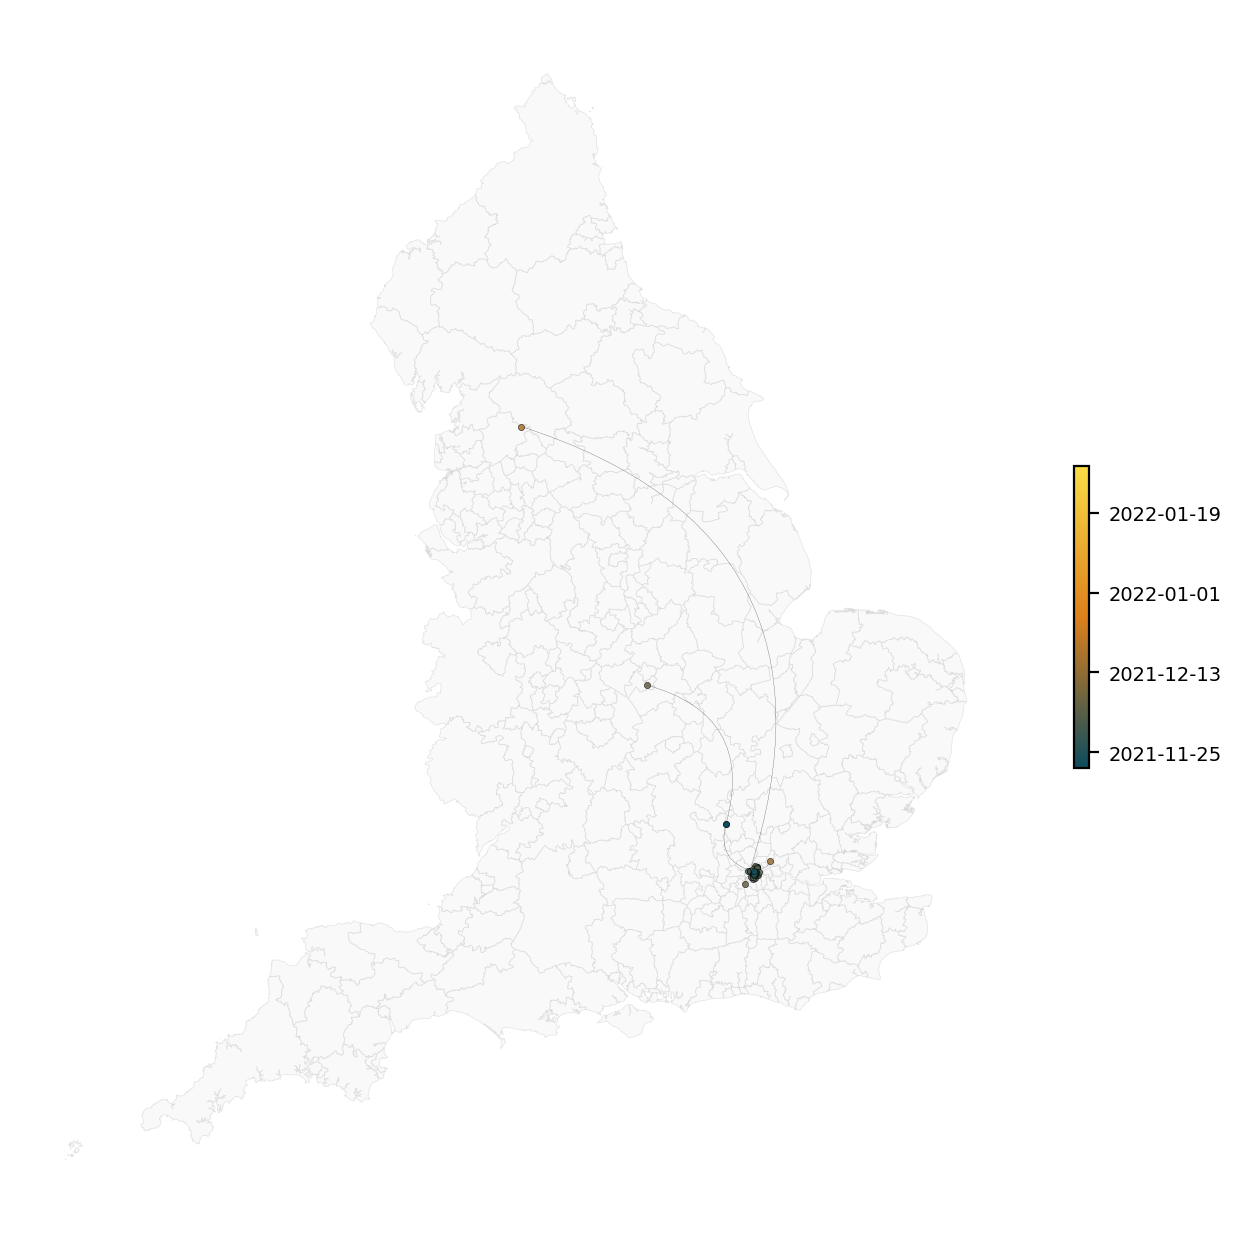

In [21]:
## specify date cut-off
cutoff_date = '2021-11-30'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)
for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()


672it [00:06, 103.12it/s]


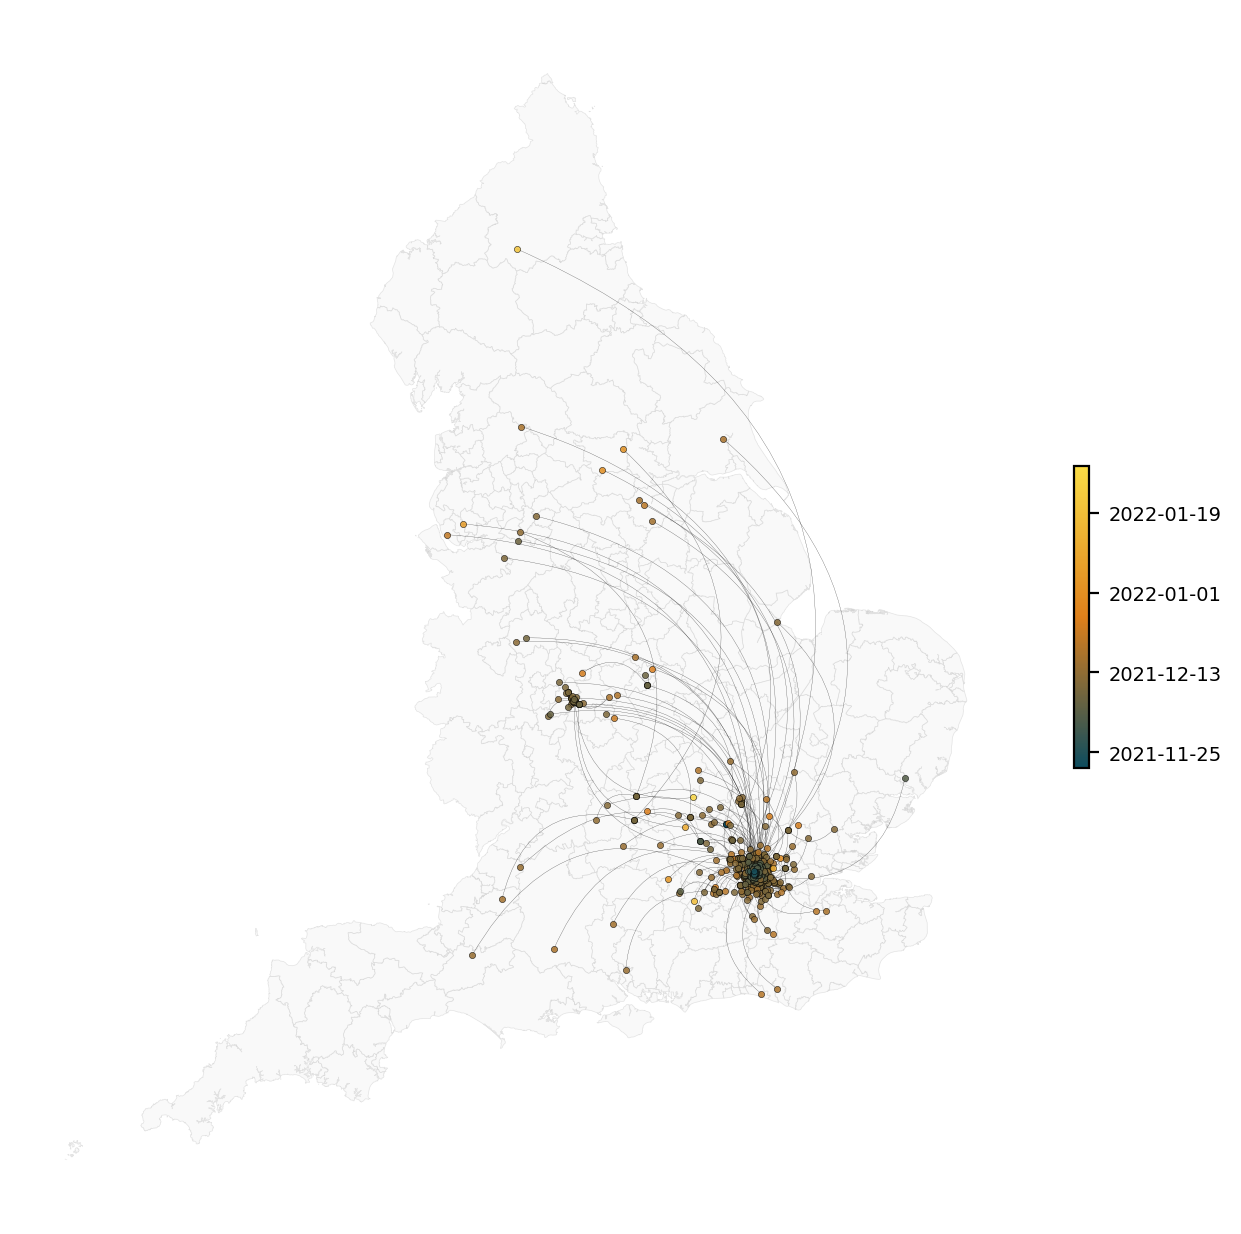

In [16]:
## specify date cut-off
cutoff_date = '2021-12-10'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)
for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()


2572it [01:19, 32.31it/s]


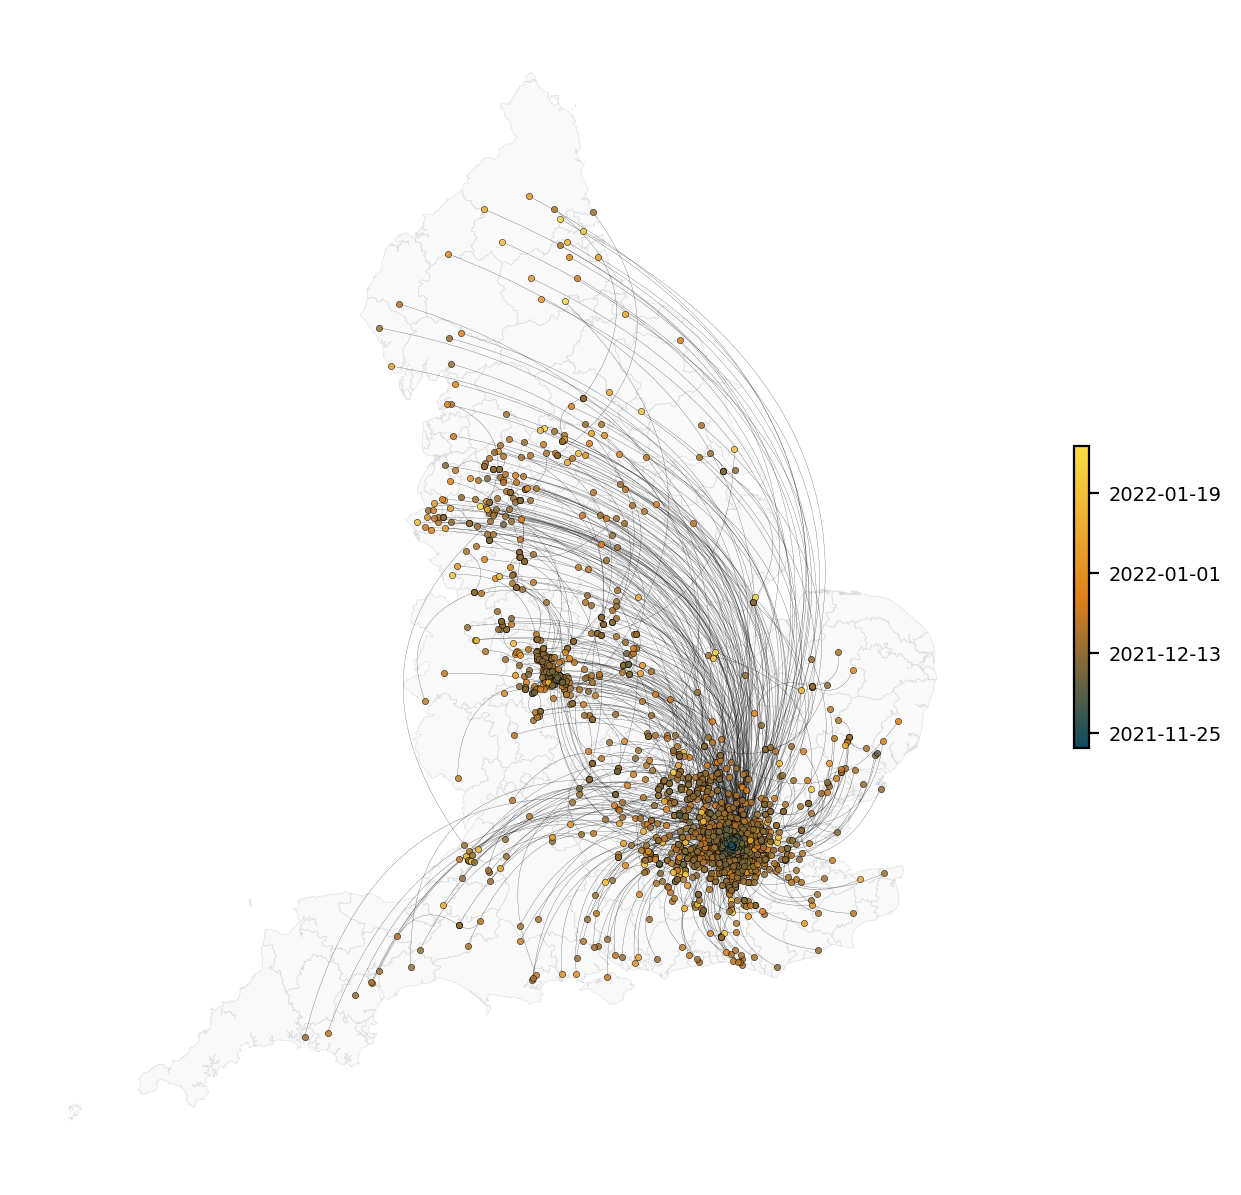

In [21]:
## specify date cut-off
cutoff_date = '2021-12-15'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)

for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()


5100it [05:08, 16.55it/s]


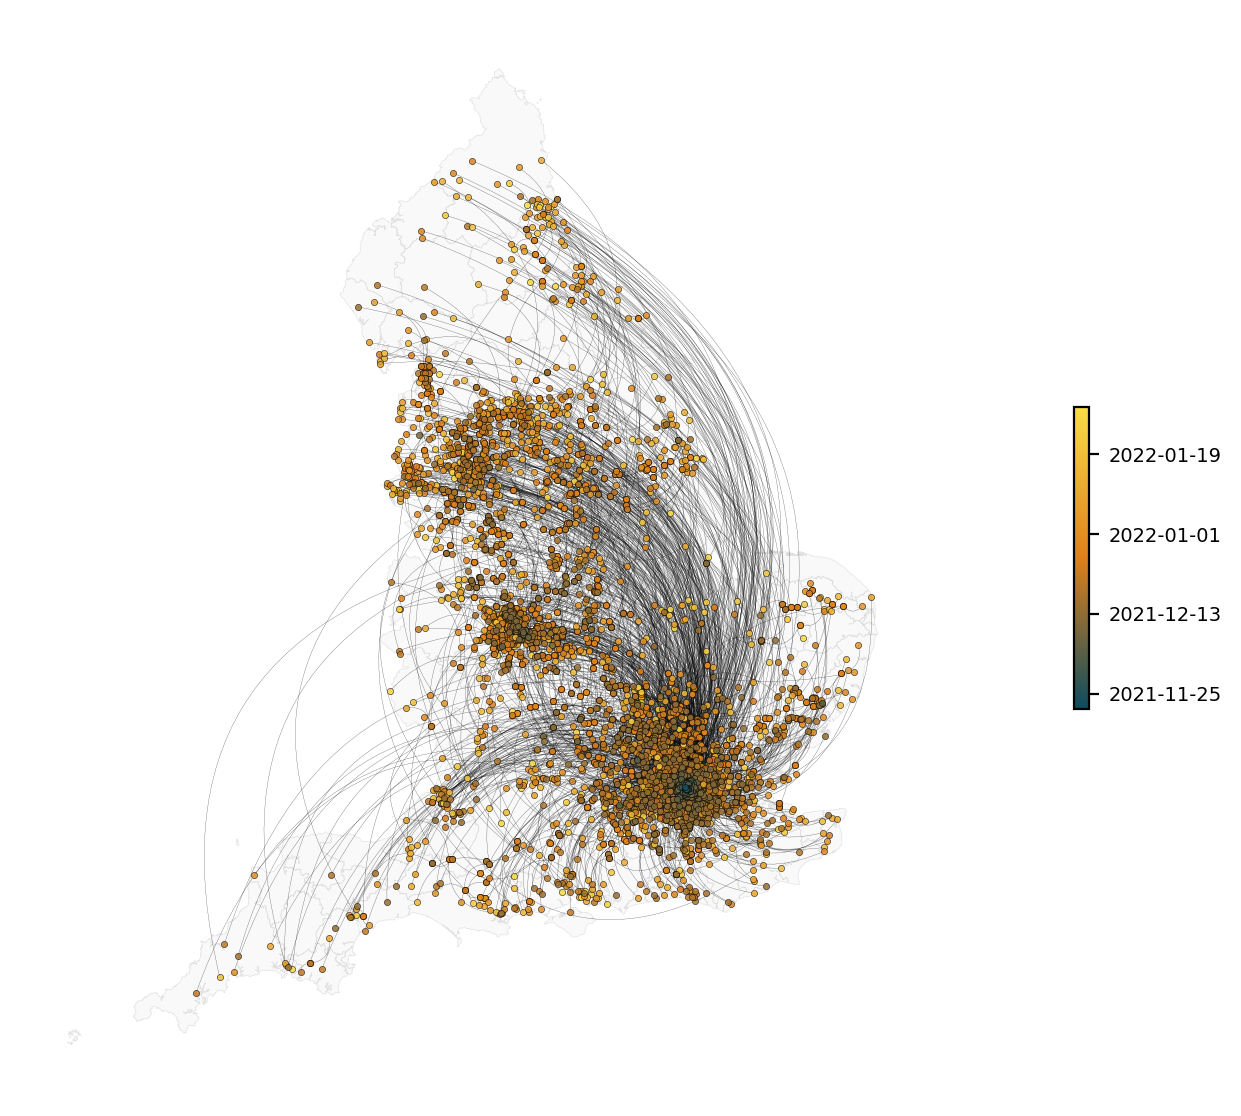

In [25]:
## specify date cut-off
cutoff_date = '2021-12-31'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)

for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()


5846it [06:49, 14.26it/s]


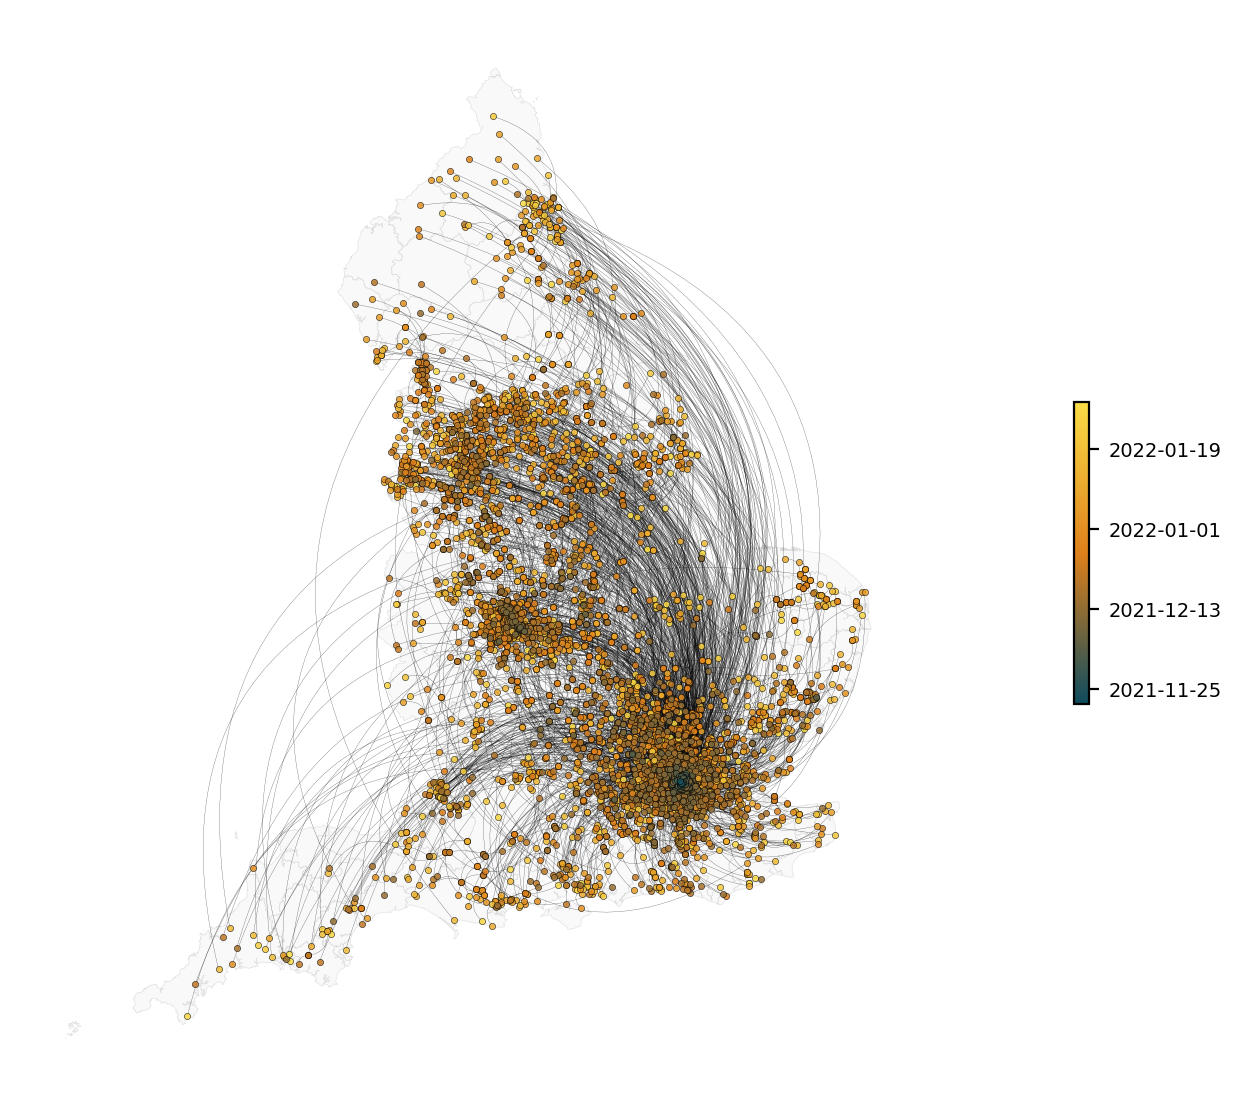

In [27]:
## specify date cut-off
cutoff_date = '2022-01-15'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)

for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()


5948it [07:11, 13.79it/s]


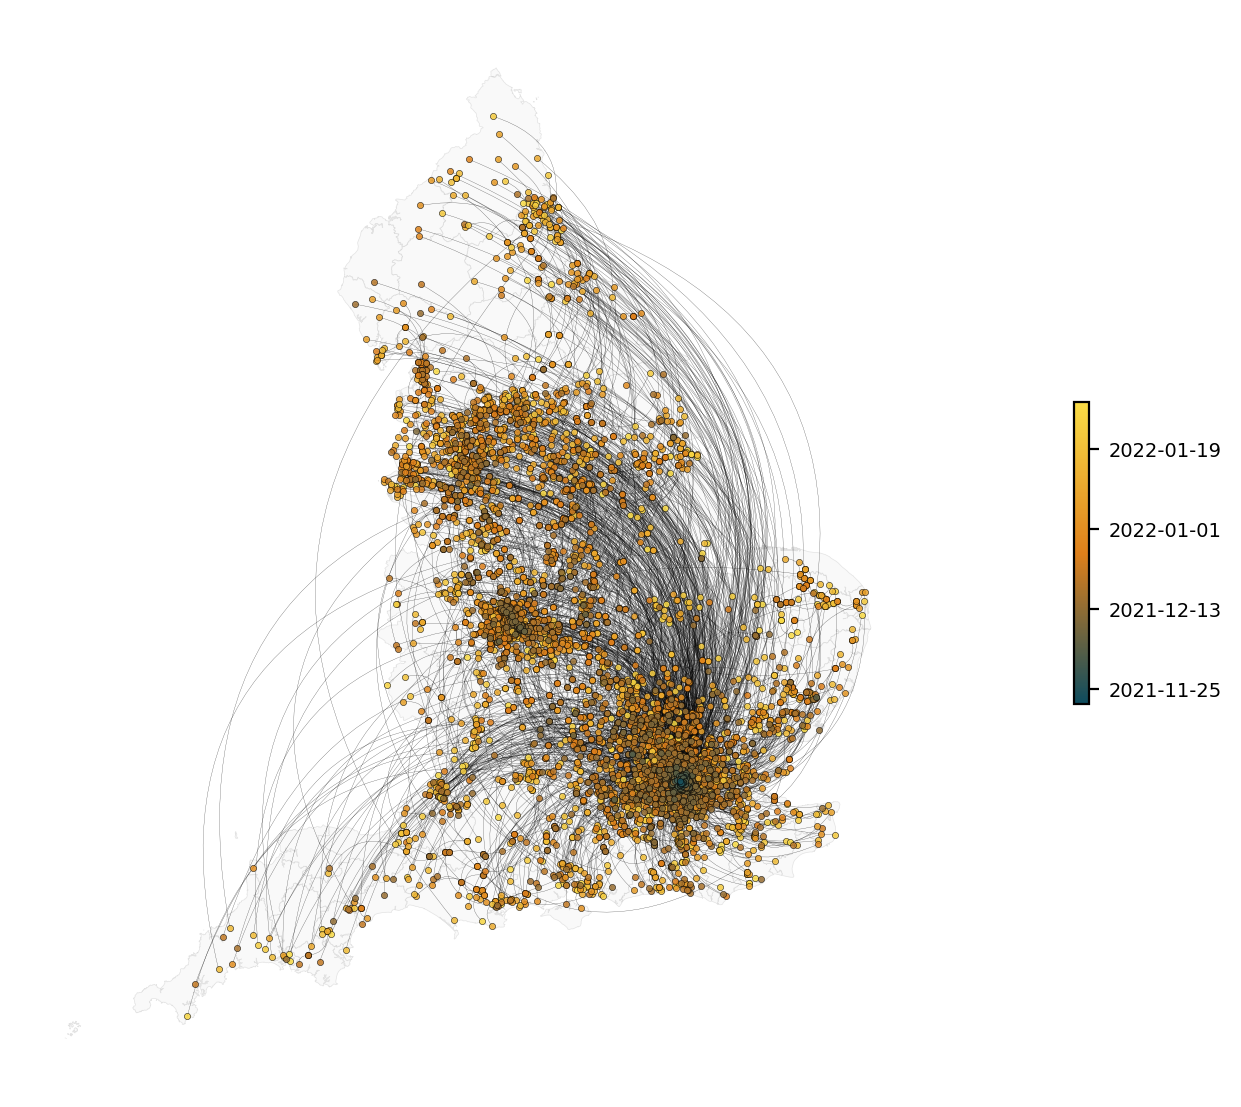

In [28]:
## specify date cut-off
cutoff_date = '2022-01-31'

## generate map
fig, ax = plt.subplots(1,1, figsize=(8, 8), dpi=200)
uk_map.plot(ax=ax, color='whitesmoke', ec='lightgrey', linewidth=0.25, alpha=0.6)

for index, row in tqdm.tqdm(mcc_edge_df[mcc_edge_df.head_date <= cutoff_date].iterrows()):
    head_pos = (row['head_long_3395'], row['head_lat_3395'])
    tail_pos = (row['tail_long_3395'], row['tail_lat_3395'])
    head_date = date_dec_map[row['head_date']]
    tail_date = date_dec_map[row['tail_date']]

    kw = dict(color="black", linewidth=0.1, alpha=0.75)

    liney = mpatches.FancyArrowPatch(head_pos, tail_pos, shrinkA=0, shrinkB=0,
                                     arrowstyle="-", connectionstyle="arc3, rad=.5", **kw)
    
    ax.add_patch(liney)

    ax.scatter(head_pos[0], head_pos[1], s=5, color=colour_dict[head_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=5)
    ax.scatter(tail_pos[0], tail_pos[1], s=5, color=colour_dict[tail_date], edgecolor='black', linewidth=0.2,
               alpha=0.85, zorder=6)

bar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=0.25)
new_ticks = []
for i in bar.get_ticks():
    new_ticks.append(get_date_str(i))
bar.set_ticks(bar.get_ticks())
bar.set_ticklabels(new_ticks)
bar.ax.tick_params(labelsize=7)

ax.set_axis_off()
        
plt.savefig("./figures/viral_movement_maps/vMov_%s_map.pdf" % cutoff_date, bbox_inches='tight', dpi=200)
    
plt.show()
